# Startups operations/close predictions

В рамках данного исследования основной целью является прогнозирование на основе данных о стартапах того, закроется ли стартап или нет. Для этого у нас есть данные о большом количестве стартапов, которые работали с 1970 по 2018 гг. Основными признаками в данных являются (1) категория деятельности стартапа, (2) признаки региона деятельности стартапа (страна, регион, город), (3) размер финансирования и количество раундов финансирования, (4) даты первого и последнего финансирования, а также (5) срок жизни стартапа.

Основными задачами исследования являются:
1. Предобработка данных - исследование на наличие дубликатов и пропущенных значений и работа с ними
2. Исследовательский анализ данных - исследование распределения признаков и взаимосвязей между ними
3. Создание новых признаков для модели на основе существующих
4. Обучение модели для прогноза факта закрытия стартапа
5. Выявление наиболее важных признако для прогноза в рамках финальной модели
6. Прогноз значения целевого признака для тестового набора данных

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight


In [2]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events kernel kernelspec lab
labextension labhub migrate nbclassic nbconvert notebook qtconsole run script
server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [3]:
!jupyter labextension list

JupyterLab v4.3.3
C:\Users\nikol\anaconda3\share\jupyter\labextensions
        catboost-widget v1.2.7 enabled ok
        jupyterlab-plotly v5.24.1 enabled  X
        @jupyter-notebook/lab-extension v7.3.1 enabled ok
        @jupyter-widgets/jupyterlab-manager v3.0.0 enabled  X (python, jupyterlab_widgets)
        @lckr/jupyterlab_variableinspector v3.1.0 enabled ok (python, lckr_jupyterlab_variableinspector)
        @pyviz/jupyterlab_pyviz v2.0.2 enabled  X (python, pyviz_comms)


   The following extensions may be outdated or specify dependencies that are incompatible with the current version of jupyterlab:
        jupyterlab-plotly
        @jupyter-widgets/jupyterlab-manager
        @pyviz/jupyterlab_pyviz
        
   If you are a user, check if an update is available for these packages.
   If you are a developer, re-run with `--verbose` flag for more details.



## Загрузка данных

Загрузим данные (тренировочную и тестовую выборки) и изучим их структуру:

In [4]:
startups_train = pd.read_csv('datasets/kaggle_startups_train_28062024.csv')
startups_test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv')

Для изучения данных напишем функцию, которая будет выдавать первые строки дата фреймов и информацию:

In [5]:
def show_data(df):
    display(df.head())
    df.info()

In [6]:
show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [7]:
show_data(startups_test)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Мы видим, что данные подгрузились верно, названия столбцов выполнены в единообразном стиле. Также мы видим несколько столбцов, которые подгрузились как тип `object`, и их нужно переделать в дату. Кроме того, мы видим различия в столбцах в тренировочных и тестовых данных - в тренировочных данных есть столбцы `founded_at` и `closed_at`, т.е. дата основания стартапа и дата его закрытия (на момент 2018-01-01), а в тестовых - `lifetime`, т.е. срок жизни стартапа. Чтобы унифицировать данные тренировочной и тестовой выборки, нам нужно будет преобразовать столбцы в тренировочной в такой же столбец, как столбец тестовой выборки, поскольку в обратную сторону этого сделать будет невозможно. Имея это всё в виду, можно приступить к предобработке данных.

## Предобработка данных

На этом этапе посмотрим на все таблицы и проверим:
- Корректность типов данных
- Наличие дубликатов
- Наличие пропущенных значений

По типам данных мы видим несколько столбцов, которые нужно преобразовать в даты, а затем посмотрим на получившиеся таблицы:

In [8]:
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

for col in date_cols:
    startups_train[col] = pd.to_datetime(startups_train[col], format='%Y-%m-%d').astype('datetime64[D]') # оставим только часть с датой
    if col in startups_test.columns: # поскольку не все столбцы есть в тестовых данных, введем условие проверки
        startups_test[col] = pd.to_datetime(startups_test[col], format='%Y-%m-%d').astype('datetime64[D]')

In [9]:
show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [10]:
show_data(startups_test)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


Типы данных преобразованы верно, соатльные типы данных отмечены верно, поэтому перейдем к поиску дубликатов. Проверим сначала полные дубликаты:

In [11]:
startups_train.duplicated().sum()

0

In [12]:
startups_test.duplicated().sum()

0

Ни в тренировочных, ни в тестовых данных нет полных дубликатов. Стоит отметить, что неполных дубликатов в этих данных сложно придумать, т.к. каждая из переменных является довольно характерной, и большинство из них вряд ли может повторяться (например, стартапы могут иметь одно и то же имя, но быть разными стартапами, но тогда у них должны отличаться какие-то еще характеристики - категория, или регион, или финансирование, или даты раундов и жизни), поэтому, чтобы точно предположить, что 2 строки - это дубликаты, то они должны быть полными дубликатами. Однако дубликаты могут быть в отдельных значениях категориальных столбцов. Посмотрим на количество уникальных значений в столбце `category_list`:

In [13]:
len(startups_train['category_list'].unique())

22106

Уникальных значений очень много, практически половина всех вариантов. Посмотрим на 20 самых часто встречающихся значений и 20 наименее частых:

In [14]:
(
    startups_train['category_list']
    .value_counts()
    .head(20)
)

Software               3207
Biotechnology          2905
E-Commerce             1064
Mobile                  920
Clean Technology        892
Curated Web             853
Health Care             744
Hardware + Software     733
Games                   681
Enterprise Software     671
Health and Wellness     613
Manufacturing           604
Advertising             554
Education               423
Semiconductors          400
Real Estate             338
Finance                 338
Consulting              330
Social Media            326
Security                317
Name: category_list, dtype: int64

In [15]:
(
    startups_train['category_list']
    .value_counts()
    .tail(20)
)

Bicycles|E-Commerce|Retail|Transportation                                                 1
Consumer Electronics|Hardware|Interface Design|Internet|Television                        1
Beauty|Marketplaces                                                                       1
Android|Apps|Exercise|Fitness|Health and Wellness|Mobile|Software|Startups|Technology     1
Food Processing|Marketplaces|Services                                                     1
Enterprise Software|Gps|Location Based Services|Mobile                                    1
Product Design|Semiconductors|Technology                                                  1
Mobile|Networking|Photography|Web Hosting                                                 1
Accounting|Creative|Music|Video                                                           1
Content|Digital Media|Music|Software|Text Analytics                                       1
Augmented Reality|Mobile Games|Virtual Worlds                                   

Мы видим, что категории работы стартапов разделены с помощью вертикальной черты, из-за чего у нас получается очень много уникальных значений категорий. Приведем категории к единому виду, сделав все буквы маленькими и на всякий случай уберем пробелы с краёв:

In [16]:
startups_train['category_list'] = startups_train['category_list'].str.lower()
startups_train['category_list'] = startups_train['category_list'].str.strip()

startups_test['category_list'] = startups_test['category_list'].str.lower()
startups_test['category_list'] = startups_test['category_list'].str.strip()

Чтобы упростить модели работу со столбцом, поступим следующим образом: 
- укрупним категории с помощью словаря (собранного вручную на тренировочной таблице). Все категории мы заменим на ключи словаря. Если категории нет в словаре, она останется такой же, а потом перейдет в категорию "другое"
- разделим сферы на несколько столбцов по этим супер-категориям, где отметим, относится ли стартап к данной категории или нет. Если значение в изначальном столбце пропущено, то строка в новых столбцах будет нулевой - так мы уберем пропущенные значения из таблицы
- эти новые столбцы можно использовать в классификаторе для прогноза целевой переменной

Словарь представлен ниже (он местами очень дискуссионный, конечно, над таким словарем лучше работать группой, чтобы точнее оценить разделение категорий):

In [17]:
category_mapping = {'it': ['algorithms', 'archiving', 'augmented reality', 'clean technology it', 'cloud computing', 'cloud data services', 'cloud gaming', 'cloud infrastructure', 
                           'cloud management', 'corporate it', 'crowdsourcing', 'cyber', 'data center automation', 'data centers', 'deep information technology', 
                           'early stage it', 'early-stage technology', 'embedded hardware and software', 'energy it', 'enterprise 2.0', 'enterprise application',
                           'gps', 'geospatial', 'hardware + software', 'human computer interaction', 'iaas', 'ict', 'information services', 'information technology',
                           'intelligent systems', 'internet of things', 'it management', 'm2m', 'paas', 'peer-to-peer', 'pervasive computing', 'proximity internet',
                           'rim', 'saas', 'semantic search', 'semantic web', 'smart grid', 'usability', 'user interface', 'user testing', 'video processing', 'video streaming',
                           'virtual desktop', 'virtual worlds', 'virtualization'],
                    'internet_services': ['china internet', 'domains', 'email', 'facebook applications', 'file sharing', 'google apps', 'internet', 'internet infrastructure',
                                          'internet service providers', 'internet technology', 'internet tv', 'portals', 'spam filtering', 'twitter applications', 'voip',
                                          'web browsers', 'web cms', 'web design', 'web development', 'web hosting', 'web tools'],
                    'business': ['accounting', 'angels', 'anything capital intensive', 'auctions', 'b2b', 'bpo services', 'business analytics', 'business development',
                                 'business information systems', 'business intelligence', 'business productivity', 'business services', 'business travelers', 'career management',
                                 'career planning', 'commercial real estate', 'consulting', 'corporate training', 'corporate wellness', 'coworking', 'crm', 'customer service',
                                 'employer benefits programs', 'employment', 'enterprise purchasing', 'enterprise resource planning', 'enterprise search', 'enterprise security',
                                 'enterprises', 'human resource automation', 'human resources', 'innovation management', 'intellectual asset management', 'labor optimization',
                                 'lifestyle businesses', 'local based services', 'local businesses', 'local commerce', 'local services', 'micro-enterprises', 'mobile enterprise',
                                 'office space', 'offline businesses', 'outsourcing', 'pre seed', 'procurement', 'product development services', 'product search',
                                 'professional services', 'project management', 'promotional', 'property management', 'recruiting', 'risk management', 'service industries',
                                 'service providers', 'services', 'skill assessment', 'small and medium businesses', 'social business', 'social crm', 'social entrepreneurship',
                                 'social fundraising', 'social media management', 'social recruiting', 'staffing firms', 'startups', 'subscription businesses', 'subscription service',
                                 'supply chain management', 'task management', 'tech field support', 'temporary staffing', 'unifed communications', 'utilities', 'virtual workforces',
                                 'vulnerability management', 'wealth management'],
                    'data': ['analytics', 'artificial intelligence', 'big data', 'big data analytics', 'computer vision', 'data mining', 'data visualization', 'databases',
                             'eda tools', 'face recognition', 'image recognition', 'interest graph', 'machine learning', 'natural language processing', 'predictive analytics',
                             'speech recognition', 'text analytics', 'visual search', 'visualization'],
                    'mobile': ['android', 'app discovery', 'app marketing', 'app stores', 'application performance monitoring', 'application platforms', 'apps', 'ios', 'ipad',
                               'iphone', 'ipod touch', 'mobile', 'mobile analytics', 'mobile devices', 'mobile infrastructure', 'mobile payments', 'mobile search',
                               'mobile software tools', 'mobile video', 'nfc', 'tablets', 'windows phone 7'],
                    'design': ['design', 'designers', 'graphic design', 'graphics', 'interface design', 'product design', 'user experience design'],
                    'health': ['alternative medicine', 'bio-pharm', 'clinical trials', 'cosmetic surgery', 'dental', 'diabetes', 'dietary supplements', 'doctors',
                               'electronic health records', 'fertility', 'first aid', 'health and insurance', 'health and wellness', 'health care', 'health care information technology',
                               'health diagnostics', 'health services industry', 'healthcare services', 'hospitals', 'independent pharmacies', 'medical', 'medical devices',
                               'medical professionals', 'medication adherence', 'mhealth', 'mobile emergency&health', 'mobile health', 'nutraceutical', 'nutrition', 'personal health',
                               'pharmaceuticals', 'physicians', 'rehabilitation', 'senior health', 'therapeutics', 'veterinary'],
                    'activities': ['active lifestyle', 'adventure travel', 'beauty', 'bicycles', 'boating industry', 'art', 'concerts', 'charities', 'charity', 'cooking', 'creative',
                                   'digital entertainment', 'diving', 'event management', 'events', 'fitness', 'gambling', 'golf equipment', 'guide to nightlife', 'leisure',
                                   'lifestyle', 'lifestyle products', 'lotteries', 'nightclubs', 'nightlife', 'online rental', 'online reservations', 'online travel',
                                   'outdoor advertising', 'outdoors', 'pets', 'racing', 'recreation', 'resorts', 'restaurants', 'self development', 'sextech', 'sex industry',
                                   'soccer', 'social travel', 'space travel', 'spas', 'sports', 'sports stadiums', 'surfing community', 'swimming', 'theatre', 'tourism',
                                   'travel', 'travel & tourism', 'twin-tip skis', 'vacation rentals', 'weddings'],
                    'biotech': ['bioinformatics', 'biometrics', 'biotechnology', 'biotechnology and semiconductor', 'genetic testing', 'neuroscience'],
                    'software': ['cad', 'customer support tools', 'data integration', 'browser extensions', 'developer apis', 'developer tools', 'development platforms',
                                 'document management', 'enterprise software', 'software', 'home automation', 'indoor positioning', 'kinect', 'linux', 'location based services',
                                 'mac', 'motion capture', 'open source', 'operating systems', 'photo editing', 'productivity software', 'reading apps', 'salesforce killers', 'search',
                                 'software', 'software compliance', 'synchronization', 'video editing', 'webos'],
                    'hardware': ['cable', 'communications hardware', 'communications infrastructure', 'computers', 'data center infrastructure', 'enterprise hardware', 'eyewear',
                                 'flash storage', 'fpga', 'google glass', 'hardware', 'hi tech', 'high tech', 'optical communications', 'rfid', 'robotics',
                                 'semiconductor manufacturing equipment', 'semiconductors', 'smart building', 'telecommunications', 'telephony', 'unmanned air systems',
                                 'wearables', 'wireless'],
                    'marketing': ['ad targeting', 'advertising', 'advertising exchanges', 'advertising networks', 'advertising platforms', 'all markets', 'brand marketing',
                                  'cause marketing', 'consumer behavior', 'consumers', 'direct advertising', 'direct marketing', 'email marketing', 'email newsletters',
                                  'emerging markets', 'internet marketing', 'internet radio market', 'lead generation', 'lead management', 'local advertising', 'market research',
                                  'marketing automation', 'mobile advertising', 'monetization', 'multi-level marketing', 'online video advertising', 'performance marketing',
                                  'personal branding', 'point of sale', 'prediction markets', 'price comparison', 'quantitative marketing', 'sales and marketing', 'search marketing',
                                  'seo', 'social media advertising', 'social media marketing', 'social media monitoring', 'surveys', 'web presence management'],
                    'industry_construction': ['architecture', 'batteries', '3d', '3d printing', '3d technology', 'advanced materials', 'aerospace', 'chemicals', 'civil engineers',
                                              'construction', 'drones', 'electric vehicles', 'electrical distribution', 'electronics', 'engineering firms', 'furniture', 'gadget',
                                              'heavy industry', 'industrial', 'industrial automation', 'lasers', 'manufacturing', 'material science', 'mechanical solutions',
                                              'minerals', 'mining technologies', 'motors', 'nanotechnology', 'natural resources', 'renewable tech', 'sensors', 'specialty chemicals',
                                              'textiles'],
                    'logistics': ['auto', 'b2b express delivery', 'logistics', 'logistics company', 'fleet management', 'limousines', 'navigation', 'maps', 'parking',
                                  'postal and courier services', 'public transportation', 'ride sharing', 'shipping', 'shipping broker industry', 'taxis', 'transportation',
                                  'utility land vehicles'],
                    'energy_tech': ['biofuels', 'biomass power generation', 'carbon', 'clean energy', 'commercial solar', 'concentrated solar power', 'energy', 'energy efficiency',
                                    'energy management', 'energy storage', 'fuel cells', 'fuels', 'gas', 'industrial energy efficiency', 'natural gas uses', 'oil', 'oil & gas',
                                    'oil and gas', 'renewable energies', 'residential solar', 'rural energy', 'solar', 'wind'],
                    'education': ['alumni', 'charter schools', 'college campuses', 'college recruiting', 'colleges', 'edtech', 'education', 'educational games', 'edutainment',
                                  'high school students', 'high schools', 'k-12 education', 'language learning', 'music education', 'online education', 'private school', 'teachers',
                                  'teaching stem concepts', 'technical continuing education', 'textbooks', 'training', 'tutoring', 'universities', 'university students'],
                    'media': ['broadcasting', 'celebrity', 'comics', 'audio', 'audiobooks', 'content creators', 'digital media', 'ebooks', 'e-books', 'entrepreneur', 'guides',
                              'in-flight entertainment', 'film', 'entertainment', 'entertainment industry', 'independent music', 'independent music labels', 'journalism',
                              'creative industries', 'film distribution', 'film production', 'media', 'music', 'music services', 'music venues', 'musical instruments', 'musicians',
                              'news', 'notebooks', 'opinions', 'performing arts', 'photo sharing', 'photography', 'podcast', 'public relations', 'publishing', 'social television',
                              'television', 'tv production', 'tv station', 'video', 'video on demand', 'writers'],
                    'finance': ['banking', 'billing', 'bitcoin', 'brokers', 'consumer lending', 'credit', 'credit cards', 'crowdfunding', 'cryptocurrency', 'debt collecting',
                                'estimation and quoting', 'finance', 'finance technology', 'financial exchanges', 'financial services', 'fintech', 'gold', 'hedge funds',
                                'impact investing', 'insurance', 'insurance companies', 'investment management', 'p2p money transfer', 'payments', 'personal finance',
                                'real estate investors', 'social investing', 'sponsorship', 'stock exchanges', 'trading', 'vending and concessions', 'venture capital',
                                'ventures for good', 'virtual currency'],
                    'social_tech': ['blogging platforms', 'chat', 'communities', 'forums', 'group sms', 'match-making', 'meeting software', 'messaging', 'microblogging',
                                    'mobile social', 'networking', 'online dating', 'private social networking', 'professional networking', 'sms', 'sns', 'social bookmarking',
                                    'social media', 'social media agent', 'social media platforms', 'social network media', 'social news', 'social opinion platform', 'social search',
                                    'video chat', 'video conferencing'],
                    'cybersecurity': ['cloud security', 'cyber security', 'data privacy', 'data security', 'fraud detection', 'identity management', 'information security',
                                      'it and cybersecurity', 'mobile security', 'network security', 'personal data', 'privacy', 'trusted networks'],
                    'environment_agricult': ['air pollution control', 'agriculture', 'animal feed', 'aquaculture', 'cannabis', 'clean technology', 'coffee', 'brewing', 'craft beer',
                                             'environmental innovation', 'farmers market', 'farming', 'flowers', 'fruit', 'green', 'green building', 'green consumer goods', 'greentech',
                                             'home & garden', 'hunting industry', 'food processing', 'organic', 'organic food', 'recycling', 'specialty foods', 'sustainability', 'tea',
                                             'waste management', 'water', 'water purification'],
                    'demographies': ['babies', 'baby accessories', 'baby boomers', 'baby safety', 'child care', 'demographies', 'east africa', 'elder care', 'elderly', 'english-speaking',
                                     'families', 'generation y-z', 'home owners', 'indians', 'kids', 'mens specific', 'mothers', 'parenting', 'retirement', 'senior citizens',
                                     'south east asia', 'teenagers', 'underserved children', 'west africa', 'women', 'young adults'],
                    'commerce': ['automated kiosk', 'call center automation', 'commodities', 'comparison shopping', 'consumer electronics', 'consumer goods', 'contact centers', 'coupons',
                                 'custom retail', 'delivery', 'digital signage', 'direct sales', 'discounts', 'distribution', 'distributors', 'e-commerce', 'e-commerce platforms',
                                 'flash sales', 'franchises', 'gift card', 'groceries', 'group buying', 'lingerie', 'local coupons', 'loyalty programs', 'marketplaces', 'mobile commerce',
                                 'mobile coupons', 'mobile shopping', 'online shopping', 'retail', 'retail technology', 'reviews and recommendations', 'sales automation', 'shoes',
                                 'shopping', 'skate wear', 'social buying', 'social commerce', 'specialty retail', 'sporting goods', 'sunglasses', 'ticketing', 'toys', 'uv leds',
                                 'lighting', 'virtual goods', 'watch', 'wholesale', 'wine and spirits'],
                    'games': ['casual games', 'console gaming', 'fantasy sports', 'freetoplay gaming', 'game', 'game mechanics', 'games', 'gamification', 'mmo games', 'mobile games',
                              'online gaming', 'pc gaming', 'serious games', 'skill gaming', 'social games', 'video game tournaments', 'video games'],
                    'legal': ['law enforcement', 'legal', 'intellectual property', 'licensing', 'reputation']}

Поменяем категории на их лейблы в словаре:

In [18]:
# перевернем словарь, чтобы одной категории в данных соответствовал один лейбл, который мы хотим привязать к этой категории
mapping_reversed = {category: label for label, categories in category_mapping.items() for category in categories}

# функция пройдется по столбцу category_list, разделит его по символу '|', переименует нашедшиеся категории в лейблы по словарю и склеит обратно
def map_categories(df_col):
    if pd.isna(df_col):
        return df_col # если значение пропущено, то выдавать его
    categories = df_col.split('|')
    mapped_categories = set([mapping_reversed.get(category, category) for category in categories]) #set уберет дубликаты лейблов
    return '|'.join(mapped_categories)

startups_train['category_list_2'] = startups_train['category_list'].apply(map_categories)
startups_test['category_list_2'] = startups_test['category_list'].apply(map_categories)

In [19]:
(
    startups_train['category_list_2']
    .value_counts()
    .head(20)
)

software                 4091
biotech                  2913
health                   2503
commerce                 1606
mobile                   1206
environment_agricult     1109
finance                  1020
it                        991
media                     962
industry_construction     900
curated web               853
games                     815
business                  785
marketing                 738
education                 688
social_tech               641
activities                634
hardware                  561
biotech|health            542
internet_services         499
Name: category_list_2, dtype: int64

In [20]:
(
    startups_train['category_list_2']
    .value_counts()
    .tail(20)
)

health|activities|curated web|education                         1
health|data|simulation|internet_services|media                  1
online identity|transaction processing|business                 1
data|social_tech|media|tracking                                 1
marketing|commerce|software|qr codes                            1
security|marketing                                              1
marketing|data|mobile|commerce|software                         1
cybersecurity|it|social_tech|software|hardware                  1
activities|media|recipes                                        1
collaborative consumption|health|legal|business                 1
social_tech|finance|software|business                           1
technology|activities|hotels|business                           1
marketing|internet_services|content|business                    1
business|commerce|curated web|education                         1
data|commerce|automotive|finance|education|internet_services    1
mobile|env

Посчитаем все получившиеся лейблы и категории после преобразования. Для этого разделим значения столбца на отдельные категории и посчитаем их количество с помощью `collections.Counter`:

In [21]:
all_labels = []

for label in startups_train['category_list_2']:
    if pd.notna(label):
        sublabels = label.split('|')
        all_labels.extend(sublabels)

labels_counts = pd.Series(Counter(all_labels))

In [22]:
labels_counts_top20 = labels_counts.sort_values(ascending=False).head(20)
labels_counts_top20

software                 10453
commerce                  6691
business                  6595
mobile                    5969
it                        5829
media                     4757
health                    4714
social_tech               4303
marketing                 4092
biotech                   3751
internet_services         3642
activities                3633
finance                   3077
data                      2879
curated web               2407
industry_construction     2377
games                     2225
environment_agricult      2086
hardware                  2081
education                 1958
dtype: int64

Мы видим получившиеся топ-20 категорий. Этот топ мы будем использовать как столбцы для рассмотрения категорий, а остальные лейблы будем рассматривать в качестве "других" категорий. Сформируем эти столбцы-индикаторы:

In [23]:
# Список категорий для столбцов:
cats_top20 = labels_counts_top20.index.to_list()

def map_labels(category_col):
    # Инициируем новые столбцы
    result = {
    'cat_software': 0,
    'cat_commerce': 0,
    'cat_business': 0,
    'cat_mobile': 0,
    'cat_it': 0,
    'cat_media': 0,
    'cat_health': 0,
    'cat_social_tech': 0,
    'cat_marketing': 0,
    'cat_biotech': 0,
    'cat_internet_services': 0,
    'cat_activities': 0,
    'cat_finance': 0,
    'cat_data': 0,
    'cat_curated web': 0,
    'cat_industry_construction': 0,
    'cat_games': 0,
    'cat_environment_agricult': 0,
    'cat_hardware': 0,
    'cat_education': 0
}
    
    if pd.notna(category_col):
        categories = set(category_col.split('|'))
        
        # Update the result dictionary
        for label in cats_top20:
            if label in categories:
                result['cat_'+label] = 1
        
        if not categories.issubset(cats_top20):
            result['cat_other'] = 1
        else:
            result['cat_other'] = 0
            
    else:
        result['cat_other'] = 0

    return pd.Series(result)

label_columns = startups_train['category_list_2'].apply(map_labels)
startups_train = pd.concat([startups_train, label_columns], axis=1)

label_test_columns = startups_test['category_list_2'].apply(map_labels)
startups_test = pd.concat([startups_test, label_test_columns], axis=1)

show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_activities,cat_finance,cat_data,cat_curated web,cat_industry_construction,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,1,0,0,0,0,0,0,0,0,0
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,0,0,1,0,0,0,0,0
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,0,0,0
3,Sancilio and Company,health care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,...,0,0,0,0,0,0,0,0,0,0
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,0,0,0,1,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               47014 non-null  object        
 5   state_code                 45753 non-null  object        
 6   region                     46157 non-null  object        
 7   city                       46157 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Посмотрим на следующий столбец - `country_code`:

In [24]:
print("Количество уникальных стран", len(startups_train['country_code'].unique()))
startups_train['country_code'].value_counts().head(20)

Количество уникальных стран 135


USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
FRA      916
DEU      834
ISR      767
ESP      607
NLD      380
AUS      379
SWE      373
RUS      369
SGP      356
BRA      355
IRL      351
ITA      321
JPN      314
KOR      300
CHE      262
Name: country_code, dtype: int64

Мы видим, что всего в данных стартапы из 135 стран. Для упрощения работы с данными возьмем так же 20 топ-стран, остальным странам дадим категорию другое. Но сначала заполним пропущенные страны категорией 'unknown', чтобы они не попали в категорию другого:

In [25]:
top_countries = startups_train['country_code'].value_counts().head(20).index.to_list()
top_countries.append('unknown') # Добавим неизвестную страну в список для сверки

startups_train.loc[startups_train['country_code'].isna(), 'country_code'] = 'unknown'
startups_train['country_code_top'] = startups_train['country_code'].apply(lambda x: x if x in top_countries else 'other')

startups_test.loc[startups_test['country_code'].isna(), 'country_code'] = 'unknown'
startups_test['country_code_top'] = startups_test['country_code'].apply(lambda x: x if x in top_countries else 'other')

show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_finance,cat_data,cat_curated web,cat_industry_construction,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other,country_code_top
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,0,0,0,CHE
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,0,1,0,0,0,0,0,USA
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,0,0,USA
3,Sancilio and Company,health care,22250000.0,operating,unknown,NaN,NaN,NaN,3,2004-01-01,...,0,0,0,0,0,0,0,0,0,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,0,0,1,0,0,0,0,0,USA


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 45753 non-null  object        
 6   region                     46157 non-null  object        
 7   city                       46157 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Пропуски в столбце страна заполнены, а также столбец обработан, чтобы его было проще обработать моделью, а также чтобы уменьшить шум от малопредставленных стран. Посмотрим теперь на переменную `state_code`: 

In [26]:
print("Количество уникальных кодов штата", len(startups_train['state_code'].unique()))
print("Количество пропусков кодов штата", startups_train['state_code'].isna().sum())
startups_train['state_code'].value_counts().head(20)

Количество уникальных кодов штата 301
Количество пропусков кодов штата 6763


CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
7      1095
FL     1038
WA      997
2       913
IL      859
PA      795
CO      735
ON      721
5       630
A8      601
16      590
VA      581
GA      570
NJ      560
OH      520
Name: state_code, dtype: int64

Посмотрим, сколько кодов пропущено для пропущенных стран и для непропущенных стран:

In [27]:
print('Доля пропущенных кодов штатов в неизвестных странах:', startups_train.loc[startups_train['country_code'] == 'unknown', 'state_code'].isna().mean())
print('Доля пропущенных кодов штатов в известных странах:', startups_train.loc[startups_train['country_code'] != 'unknown', 'state_code'].isna().mean())

Доля пропущенных кодов штатов в неизвестных странах: 1.0
Доля пропущенных кодов штатов в известных странах: 0.026821797762368656


В целом мы видим, что все коды штатов в неизвестных странах пропущены. Поэтому для таких случаев можно заменить код на всё тот же 'unknown'. Для штатов в известных странах мы можем использовать стратегию подстановки самого популярного кода штата в данной стране, однако это мы сделаем на этапе подготовки данных. Так же, как и в предыдущих случаях, выделим 20 самых популярных штатов, и заполним остальные штаты "другим" значением:

In [28]:
top_states = startups_train['state_code'].value_counts().head(20).index.to_list()
top_states.append('unknown')

startups_train.loc[startups_train['country_code'] == 'unknown', 'state_code'] = 'unknown'
startups_test.loc[startups_test['country_code'] == 'unknown', 'state_code'] = 'unknown'

def map_state_code(state_code):
    if pd.isna(state_code):
        return np.nan
    elif state_code in top_states:
        return state_code
    else:
        return 'other'

startups_train['state_code_top'] = startups_train['state_code'].apply(map_state_code)

startups_test['state_code_top'] = startups_test['state_code'].apply(map_state_code)

show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_data,cat_curated web,cat_industry_construction,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other,country_code_top,state_code_top
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,0,0,CHE,other
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,1,0,0,0,0,0,USA,CA
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,0,USA,CA
3,Sancilio and Company,health care,22250000.0,operating,unknown,unknown,NaN,NaN,3,2004-01-01,...,0,0,0,0,0,0,0,0,unknown,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,0,1,0,0,0,0,0,USA,VA


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 51255 non-null  object        
 6   region                     46157 non-null  object        
 7   city                       46157 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Аналогично посмотрим на регионы:

In [29]:
print('Доля пропущенных регионов в неизвестных странах:', startups_train.loc[startups_train['country_code'] == 'unknown', 'region'].isna().mean())
print('Доля пропущенных регионов в известных странах:', startups_train.loc[startups_train['country_code'] != 'unknown', 'region'].isna().mean())

Доля пропущенных регионов в неизвестных странах: 1.0
Доля пропущенных регионов в известных странах: 0.01822861275364785


Мы видим аналогичную картину. Поэтому проведем аналогичный анализ и преобразования для регионов:

In [30]:
print("Количество уникальных регионов", len(startups_train['region'].unique()))
print("Количество пропусков регионов", startups_train['region'].isna().sum())
startups_train['region'].value_counts().head(20)

Количество уникальных регионов 1037
Количество пропусков регионов 6359


SF Bay Area         6970
New York City       2776
Boston              1890
London              1840
Los Angeles         1513
Seattle              955
Washington, D.C.     817
Chicago              778
San Diego            703
Austin               652
Denver               638
Toronto              591
Tel Aviv             571
Paris                546
Atlanta              538
Newark               472
Dallas               468
Beijing              464
Philadelphia         434
Anaheim              405
Name: region, dtype: int64

In [31]:
top_regions = startups_train['region'].value_counts().head(20).index.to_list()
top_regions.append('unknown')

startups_train.loc[startups_train['country_code'] == 'unknown', 'region'] = 'unknown'
startups_test.loc[startups_test['country_code'] == 'unknown', 'region'] = 'unknown'

def map_region(region):
    if pd.isna(region):
        return np.nan
    elif region in top_regions:
        return region
    else:
        return 'other'

startups_train['region_top'] = startups_train['region'].apply(map_region)

startups_test['region_top'] = startups_test['region'].apply(map_region)

show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_curated web,cat_industry_construction,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other,country_code_top,state_code_top,region_top
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,0,CHE,other,other
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,1,0,0,0,0,0,USA,CA,SF Bay Area
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,0,USA,CA,SF Bay Area
3,Sancilio and Company,health care,22250000.0,operating,unknown,unknown,unknown,NaN,3,2004-01-01,...,0,0,0,0,0,0,0,unknown,unknown,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,1,0,0,0,0,0,USA,VA,other


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 51255 non-null  object        
 6   region                     51659 non-null  object        
 7   city                       46157 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Аналогично посмотрим на города:

In [32]:
print('Доля пропущенных регионов в неизвестных регионах:', startups_train.loc[startups_train['region'] == 'unknown', 'city'].isna().mean())
print('Доля пропущенных регионов в известных регионах:', startups_train.loc[startups_train['region'] != 'unknown', 'city'].isna().mean())

Доля пропущенных регионов в неизвестных регионах: 1.0
Доля пропущенных регионов в известных регионах: 0.01822861275364785


In [33]:
print("Количество уникальных городов", len(startups_train['city'].unique()))
print("Количество пропусков городов", startups_train['city'].isna().sum())
startups_train['city'].value_counts().head(20)

Количество уникальных городов 4478
Количество пропусков городов 6359


San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         607
Los Angeles       604
Seattle           592
Chicago           546
Cambridge         542
Boston            508
Paris             485
San Diego         480
Beijing           464
Mountain View     463
Toronto           429
San Jose          359
Sunnyvale         358
Atlanta           346
Singapore         341
Bangalore         307
Name: city, dtype: int64

In [34]:
top_city = startups_train['city'].value_counts().head(20).index.to_list()
top_city.append('unknown')

startups_train.loc[startups_train['region'] == 'unknown', 'city'] = 'unknown'
startups_test.loc[startups_test['region'] == 'unknown', 'city'] = 'unknown'

def map_city(city):
    if pd.isna(city):
        return np.nan
    elif city in top_city:
        return city
    else:
        return 'other'

startups_train['city_top'] = startups_train['city'].apply(map_city)

startups_test['city_top'] = startups_test['city'].apply(map_city)

show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_industry_construction,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other,country_code_top,state_code_top,region_top,city_top
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,CHE,other,other,other
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,1,0,0,0,0,0,USA,CA,SF Bay Area,other
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,USA,CA,SF Bay Area,San Jose
3,Sancilio and Company,health care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,...,0,0,0,0,0,0,unknown,unknown,unknown,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,1,0,0,0,0,0,USA,VA,other,other


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 51255 non-null  object        
 6   region                     51659 non-null  object        
 7   city                       51659 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Таким образом, мы обработали категориальные переменные. Теперь обработаем данные с датой. В тренировочных данные есть столбцы 'founded_at' и 'closed_at', в то время как в тестовых - столбец 'lifetime'. Необходимо обработать столбцы в тренировочных данных, т.к.:
1. Столбец 'closed_at' будет создавать утечку в данных, т.к. он прямо говорит о том, что стартап был закрыт
2. Обратное преобразование времени жизни стартапа в даты невозможно, а также потенциально бы добавило утечку в данных.

Заполним пропущенные значения в столбце 'closed_at' датой сбора данных, т.к. пропущенное значение значит, что на эту дату ('2018-01-01') стартап еще жив:

In [35]:
startups_train.loc[startups_train['closed_at'].isna(), 'closed_at'] = '2018-01-01'
show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_industry_construction,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other,country_code_top,state_code_top,region_top,city_top
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,0,CHE,other,other,other
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,1,0,0,0,0,0,USA,CA,SF Bay Area,other
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,0,USA,CA,SF Bay Area,San Jose
3,Sancilio and Company,health care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,...,0,0,0,0,0,0,unknown,unknown,unknown,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,1,0,0,0,0,0,USA,VA,other,other


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 51255 non-null  object        
 6   region                     51659 non-null  object        
 7   city                       51659 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Теперь посчитаем количество дней жизни стартапа:

In [36]:
startups_train['lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days
show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,cat_games,cat_environment_agricult,cat_hardware,cat_education,cat_other,country_code_top,state_code_top,region_top,city_top,lifetime
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,0,0,0,0,0,CHE,other,other,other,2998
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,0,0,0,0,0,USA,CA,SF Bay Area,other,4748
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,0,0,0,0,0,USA,CA,SF Bay Area,San Jose,4383
3,Sancilio and Company,health care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,...,0,0,0,0,0,unknown,unknown,unknown,unknown,5114
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,0,0,0,0,0,USA,VA,other,other,2791


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 51255 non-null  object        
 6   region                     51659 non-null  object        
 7   city                       51659 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Посчитаем также количество полных лет жизни стартапа - это также может быть важной переменной. Из других переменных дат возьмем год и месяц первого и последнего раунда финансирования, а также разницу между датами финансирования в днях и годах:

In [37]:
startups_train['lifetime_years'] = startups_train['lifetime'] // 365
startups_test['lifetime_years'] = startups_test['lifetime'] // 365
startups_train['first_funding_year'] = startups_train['first_funding_at'].dt.year
startups_test['first_funding_year'] = startups_test['first_funding_at'].dt.year
startups_train['first_funding_month'] = startups_train['first_funding_at'].dt.month
startups_test['first_funding_month'] = startups_test['first_funding_at'].dt.month
startups_train['last_funding_year'] = startups_train['last_funding_at'].dt.year
startups_test['last_funding_year'] = startups_test['last_funding_at'].dt.year
startups_train['last_funding_month'] = startups_train['last_funding_at'].dt.month
startups_test['last_funding_month'] = startups_test['last_funding_at'].dt.month
startups_train['funding_period'] = (startups_train['last_funding_at'] - startups_train['first_funding_at']).dt.days
startups_test['funding_period'] = (startups_test['last_funding_at'] - startups_test['first_funding_at']).dt.days
startups_train['funding_period_years'] = startups_train['funding_period'] // 365
startups_test['funding_period_years'] = startups_test['funding_period'] // 365

show_data(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,region_top,city_top,lifetime,lifetime_years,first_funding_year,first_funding_month,last_funding_year,last_funding_month,funding_period,funding_period_years
0,Lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,other,other,2998,8,2011,5,2014,12,1310,3
1,EarLens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,SF Bay Area,other,4748,13,2010,5,2014,2,1393,3
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,SF Bay Area,San Jose,4383,12,2012,8,2014,7,681,1
3,Sancilio and Company,health care,22250000.0,operating,unknown,unknown,unknown,unknown,3,2004-01-01,...,unknown,unknown,5114,14,2011,9,2014,7,1051,2
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,other,other,2791,7,2012,2,2012,2,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       52515 non-null  object        
 1   category_list              50051 non-null  object        
 2   funding_total_usd          42447 non-null  float64       
 3   status                     52516 non-null  object        
 4   country_code               52516 non-null  object        
 5   state_code                 51255 non-null  object        
 6   region                     51659 non-null  object        
 7   city                       51659 non-null  object        
 8   funding_rounds             52516 non-null  int64         
 9   founded_at                 52516 non-null  datetime64[ns]
 10  first_funding_at           52516 non-null  datetime64[ns]
 11  last_funding_at            52516 non-null  datetime64[ns]
 12  clos

Остались числовые переменные - `funding_total_usd` и `funding_rounds`. В первой мы видим большое число пропущенных значений. Мы их заполним медианой на этапе подготовки данных к модели.
Предобработка данных завершена, дубликаты обработаны, пропуски заполнены (кроме тех, что следует заполнить на этапе подготовки), поэтому приступим к исследовательскому анализу данных.

## Исследовательский анализ данных

Посмотрим на то, как распределены данные в целевой и входных данных. Т.к. мы уже нагенерили синтетические входные признаки, то посмотрим именно на них, а не на изначальные признаки, тем более распределение изначальных категориальных признаков мы уже смотрели на этапе предобработки. Для числовых признаком посмотрим на сводку статистик и строить гистограмму, а для категориальных - на таблицу распределения и столбчатую или пироговую диаграмму. Начнем с целевой переменной `status`:

In [38]:
startups_train['status'].value_counts()

operating    47599
closed        4917
Name: status, dtype: int64

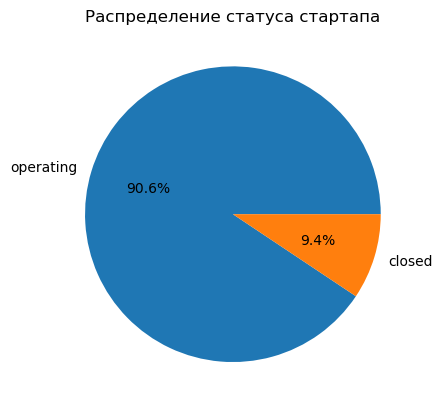

In [39]:
status_perc = startups_train['status'].value_counts() / startups_train.shape[0]
status_perc.plot.pie(title='Распределение статуса стартапа', autopct='%1.1f%%', ylabel='');

Мы видим, что данные по целевой переменной довольно сильно смещены - только около 10% стартапов закрылись. Поэтому данный факт стоит учитывать при обучении модели, чтобы дисбаланс классов не влиял на ее качество.

Посмотрим теперь на входные признаки, и начнем с `funding_total_usd`:

In [40]:
startups_train['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

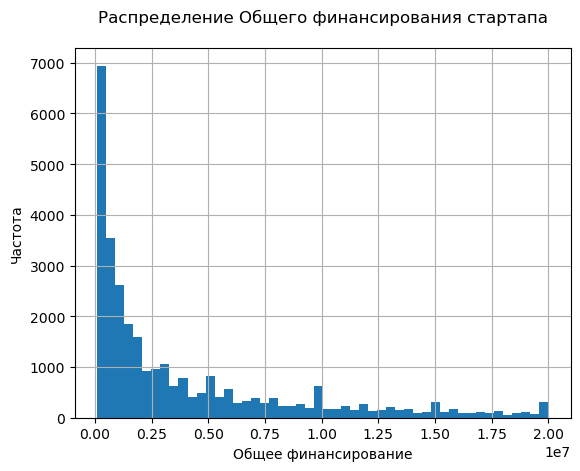

In [41]:
plt.title('Распределение Общего финансирования стартапа\n')
plt.xlabel('Общее финансирование')
plt.ylabel('Частота')
startups_train['funding_total_usd'].hist(range=(1e05, 2e07), bins=50);

Мы видим, что финансирование очень сильно скошено вправо - среднее больше медианы примерно на порядок, половина стартапов получила финансирование не больше 2 млн $, а средний стартап получил финансирование в размере от 336 тыс. до 10 млн (квартили). Теперь посмотрим на распределение переменной `funding_rounds`:

In [42]:
startups_train['funding_rounds'].describe()

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

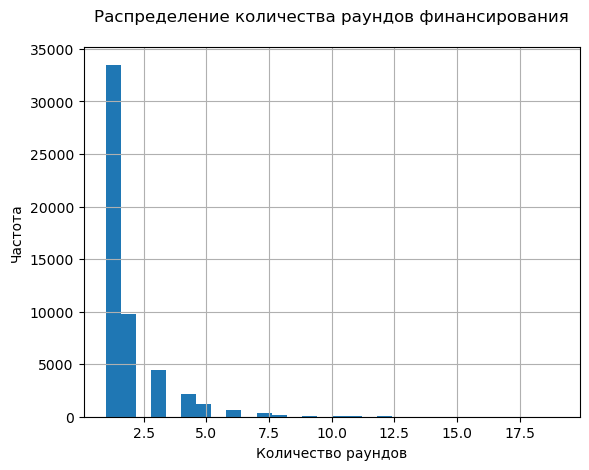

In [43]:
plt.title('Распределение количества раундов финансирования\n')
plt.xlabel('Количество раундов')
plt.ylabel('Частота')
startups_train['funding_rounds'].hist(bins=30);

Мы также видим, что данные сильно скошены вправо, не менее половины стартапов прошли только через 1 раунд финансирования. При этом в данных есть выбросы - стартапы с большим числом раундов, до 19. Посмотрим теперь на распределение показателя `lifetime`:

In [44]:
startups_train['lifetime'].describe()

count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

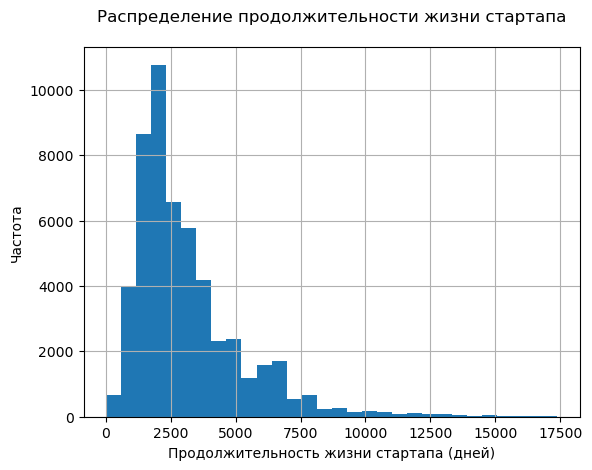

In [45]:
plt.title('Распределение продолжительности жизни стартапа\n')
plt.xlabel('Продолжительность жизни стартапа (дней)')
plt.ylabel('Частота')
startups_train['lifetime'].hist(bins=30);

В среднем стартап живет (на момент сбора данных) от 2500 до 3100 дней (среднее и медиана), а большинство стартапов имеют срок жизни от 1700 до 4000 дней. Аналогично посмотрим на годы жизни стартапов:

In [46]:
startups_train['lifetime_years'].describe()

count    52516.000000
mean         8.287931
std          5.982346
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         47.000000
Name: lifetime_years, dtype: float64

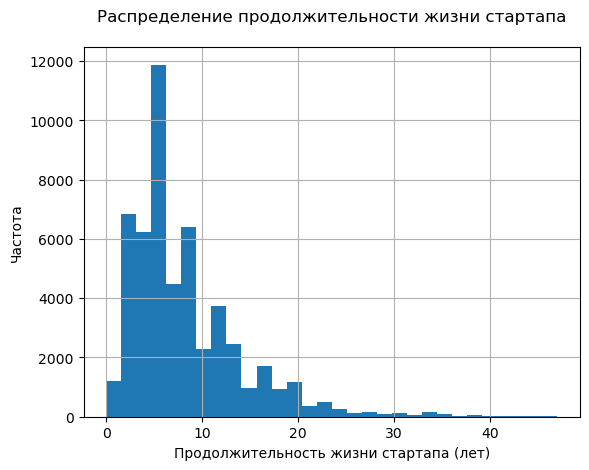

In [47]:
plt.title('Распределение продолжительности жизни стартапа\n')
plt.xlabel('Продолжительность жизни стартапа (лет)')
plt.ylabel('Частота')
startups_train['lifetime_years'].hist(bins=30);

Распределение аналогичное со средним сроком 7-8 лет. Посмотрим теперь на распределение того, в каком году стартапы получили финансирование (первое и последнее), а также на распределение разницы между 2 финансированиями:

In [48]:
startups_train['first_funding_year'].describe()

count    52516.000000
mean      2011.075691
std          3.613547
min       1977.000000
25%       2009.000000
50%       2012.000000
75%       2014.000000
max       2015.000000
Name: first_funding_year, dtype: float64

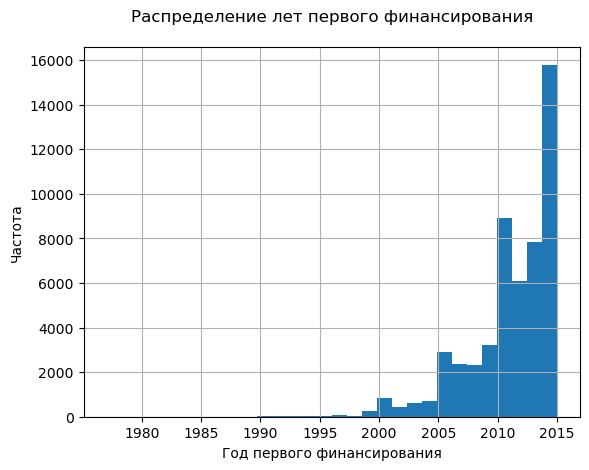

In [49]:
plt.title('Распределение лет первого финансирования\n')
plt.xlabel('Год первого финансирования')
plt.ylabel('Частота')
startups_train['first_funding_year'].hist(bins=30);

Здесь мы видим обратную картину - данные скошены влево с большинством стартапов, получивших финансирование после 2015 года.

In [50]:
startups_train['last_funding_year'].describe()

count    52516.000000
mean      2012.012491
std          3.336599
min       1977.000000
25%       2011.000000
50%       2013.000000
75%       2014.000000
max       2015.000000
Name: last_funding_year, dtype: float64

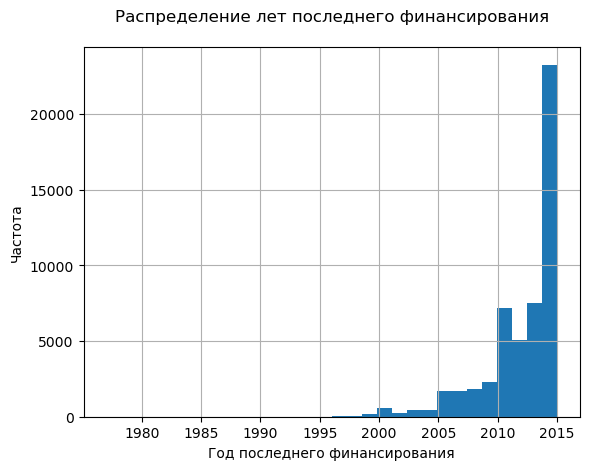

In [51]:
plt.title('Распределение лет последнего финансирования\n')
plt.xlabel('Год последнего финансирования')
plt.ylabel('Частота')
startups_train['last_funding_year'].hist(bins=30);

Распределение похоже на предыдущее, но еще более скошенное влево, что неудивительно, т.к. последнее финансирование происходит не раньше первого.

In [52]:
startups_train['funding_period'].describe()

count    52516.000000
mean       346.488994
std        688.604389
min          0.000000
25%          0.000000
50%          0.000000
75%        427.000000
max      10807.000000
Name: funding_period, dtype: float64

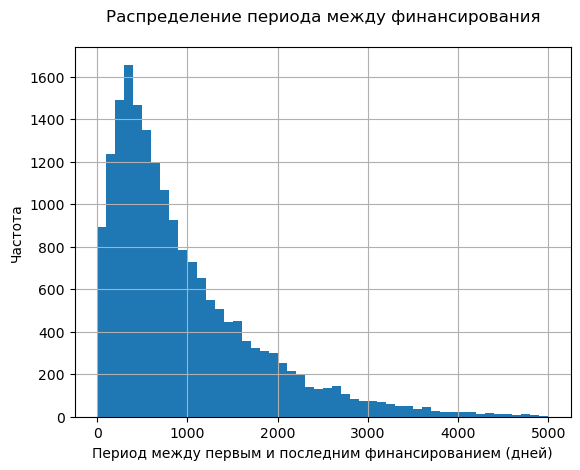

In [53]:
plt.title('Распределение периода между финансирования\n')
plt.xlabel('Период между первым и последним финансированием (дней)')
plt.ylabel('Частота')
startups_train['funding_period'].hist(range=(0.1, 5000), bins=50);

Здесь ожидаемо больше половину стартапов получили только одно финансирование, поэтому оставим на графике только небольшую долю стартапов, которые получили больше одного финансирования - среди них мы видим локальный пик на около 400-500 дней, а распределение опять же скошено вправо.

In [54]:
startups_train['funding_period_years'].describe()

count    52516.00000
mean         0.77902
std          1.74351
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max         29.00000
Name: funding_period_years, dtype: float64

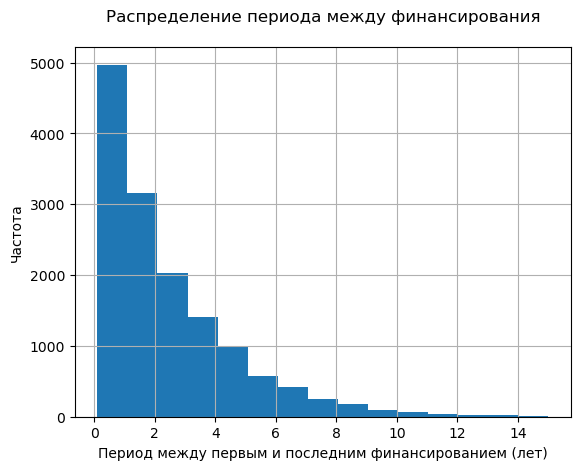

In [55]:
plt.title('Распределение периода между финансирования\n')
plt.xlabel('Период между первым и последним финансированием (лет)')
plt.ylabel('Частота')
startups_train['funding_period_years'].hist(range=(0.1, 15), bins=15);

По годам мы видим, что большинство стартапов получает финансирование в течение одного года.

Дополнительно создадим переменную среднего финансирования в раунд для стартапа и посмотрим на ее распределение:

In [56]:
startups_train['funding_per_round'] = startups_train['funding_total_usd'] / startups_train['funding_rounds']

In [57]:
startups_train['funding_per_round'].describe()

count    4.244700e+04
mean     8.914385e+06
std      8.492286e+07
min      1.000000e+00
25%      2.500000e+05
50%      1.300000e+06
75%      5.675000e+06
max      1.066494e+10
Name: funding_per_round, dtype: float64

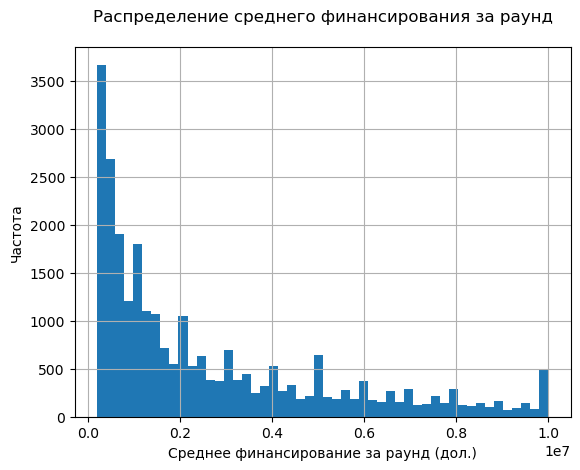

In [58]:
plt.title('Распределение среднего финансирования за раунд\n')
plt.xlabel('Среднее финансирование за раунд (дол.)')
plt.ylabel('Частота')
startups_train['funding_per_round'].hist(range=(2e05, 1e07), bins=50);

Мы посмотрели на распределение признаков, теперь посмотрим на корреляции между входными и целевым признаком для определения самых перспективных признаков для модели и возможной коллинеарности входных признаков. Для более быстрого расчета возьмем случайную выборку из 1000 строк и возьмем только те столбцы, которые мы нагенерили и будем предварительно использовать в модели:

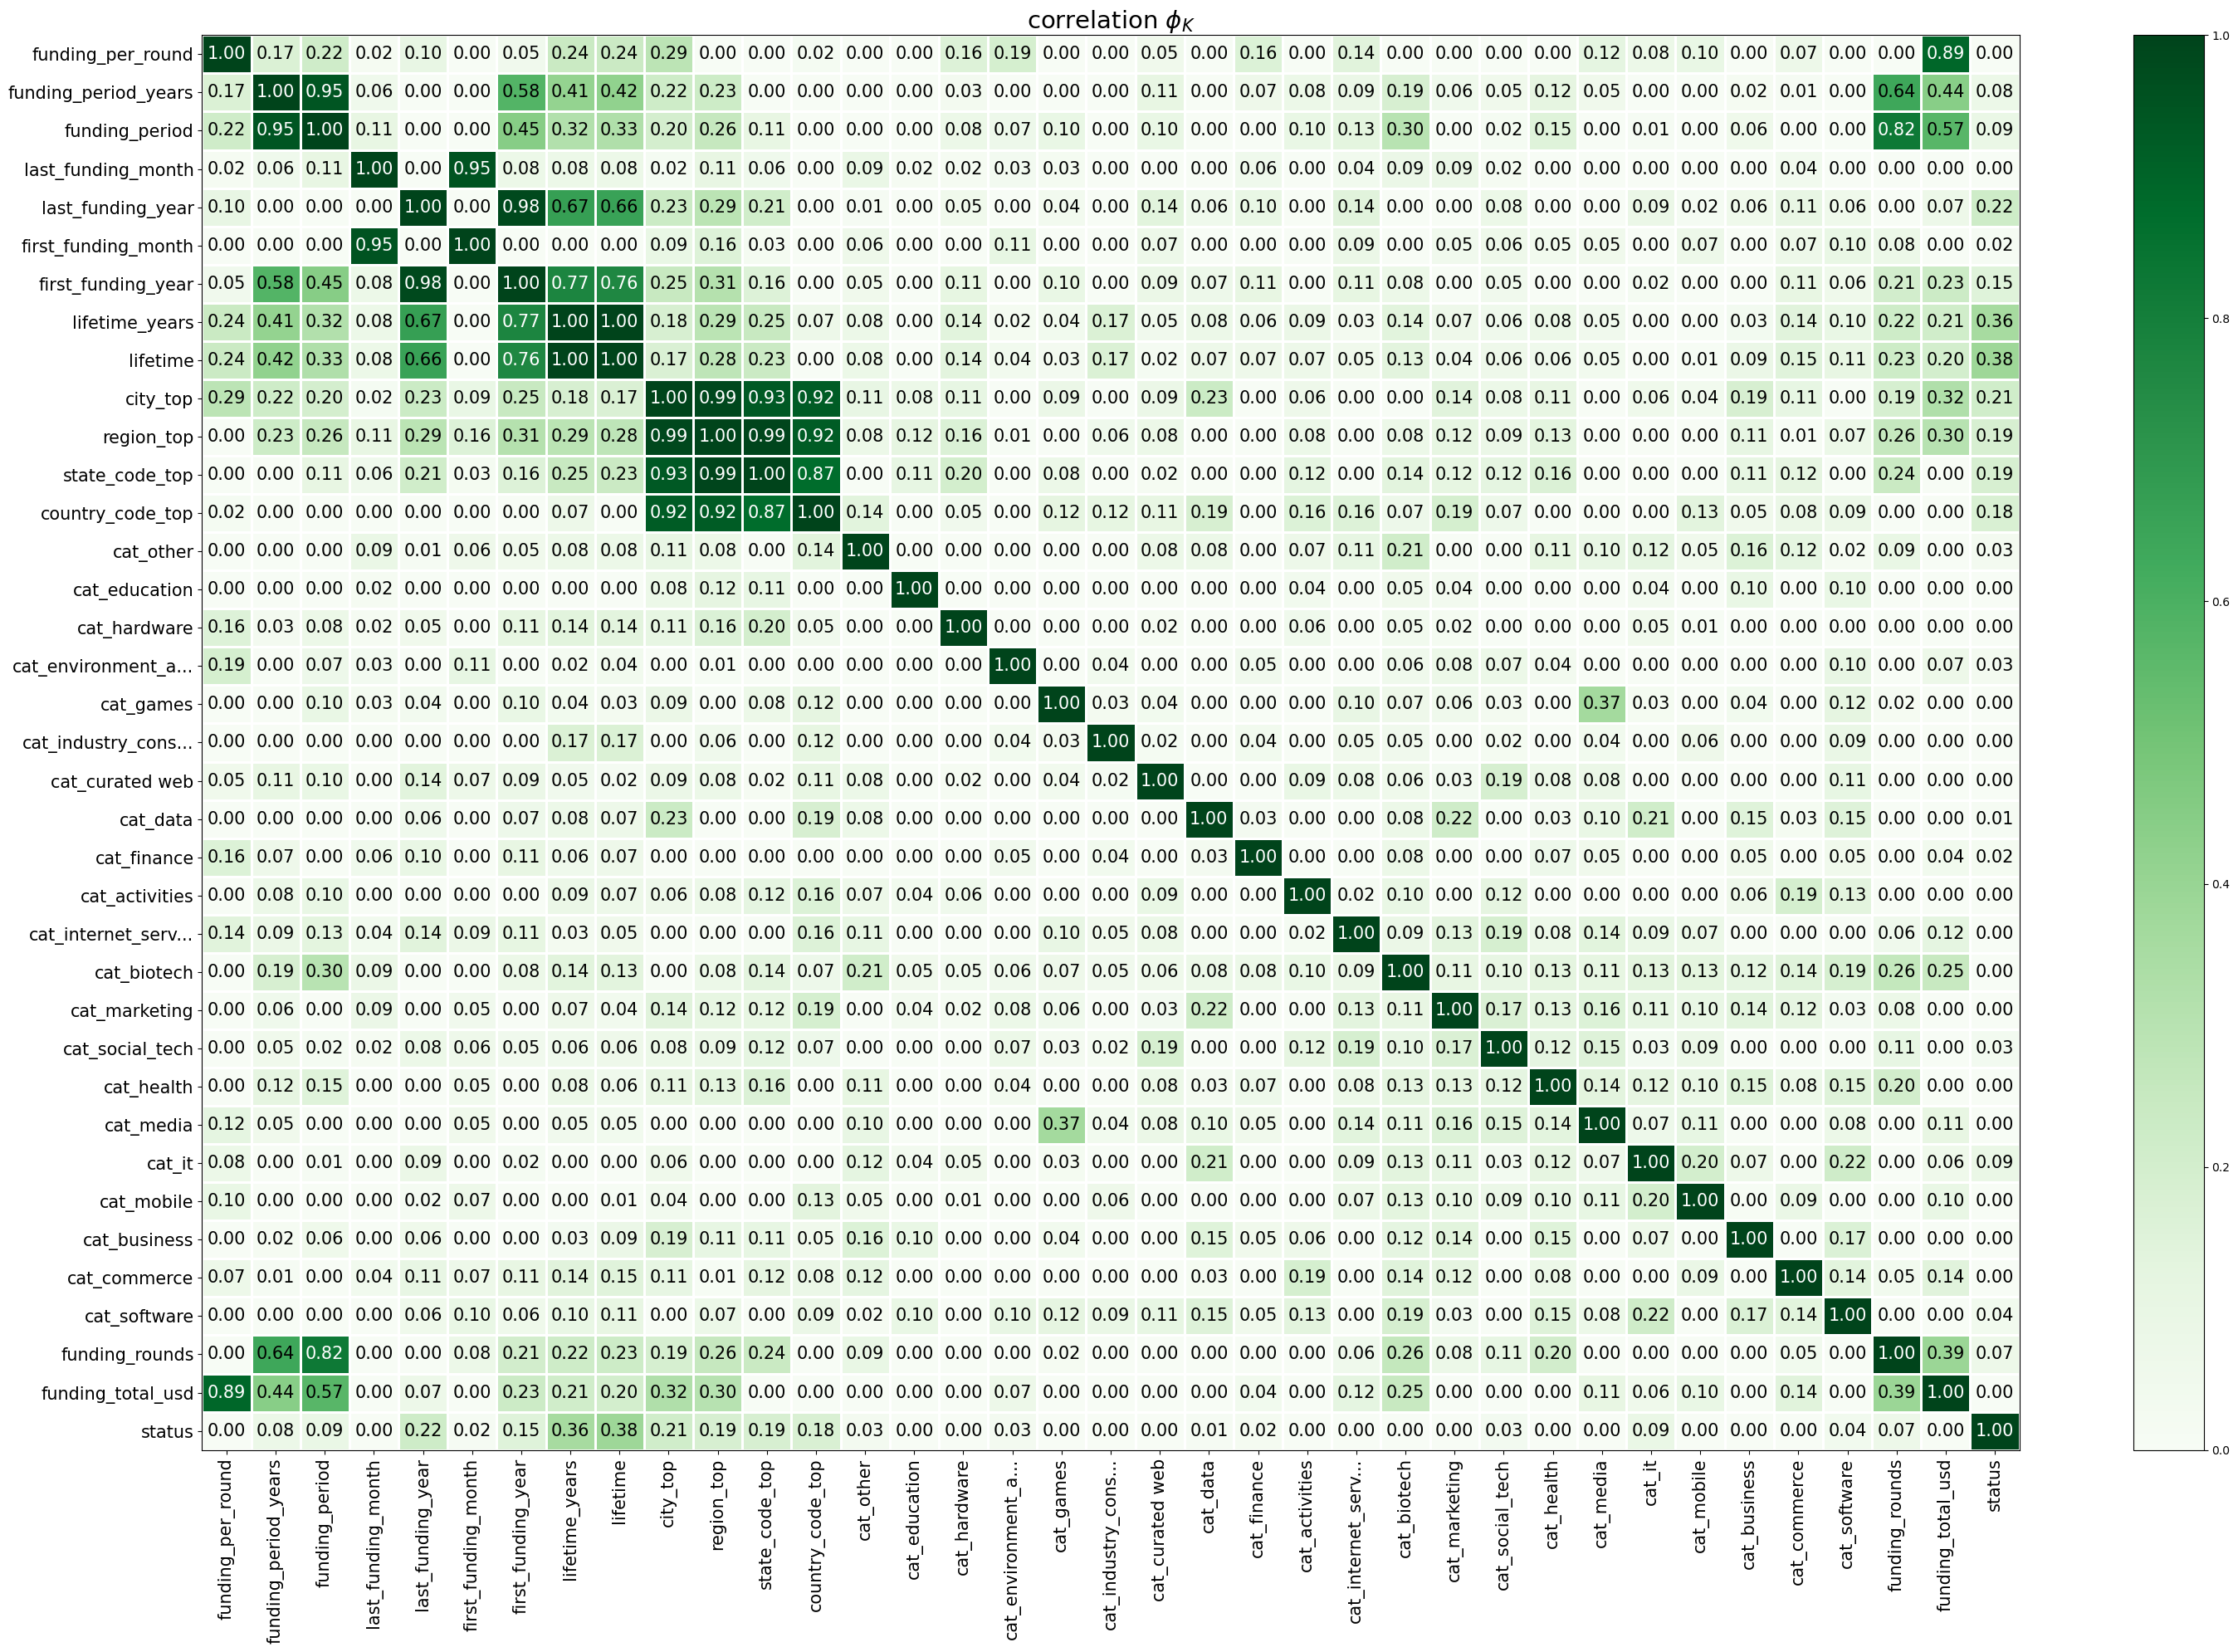

In [59]:
num_columns = ['funding_total_usd', 'funding_rounds', 'lifetime', 'lifetime_years', 
               'first_funding_year', 'first_funding_month', 'last_funding_year', 'last_funding_month',
               'funding_period', 'funding_period_years', 'funding_per_round']

startups_train_sample = startups_train.sample(n=1000, random_state=42)
startups_train_sample = startups_train_sample[['status', 'funding_total_usd', 'funding_rounds', 'cat_software', 'cat_commerce', 'cat_business', 'cat_mobile',
                                               'cat_it', 'cat_media', 'cat_health', 'cat_social_tech', 'cat_marketing', 'cat_biotech', 'cat_internet_services',
                                               'cat_activities', 'cat_finance', 'cat_data', 'cat_curated web', 'cat_industry_construction', 'cat_games', 
                                               'cat_environment_agricult', 'cat_hardware', 'cat_education', 'cat_other', 'country_code_top', 'state_code_top',
                                               'region_top', 'city_top', 'lifetime', 'lifetime_years', 'first_funding_year', 'first_funding_month', 
                                               'last_funding_year', 'last_funding_month', 'funding_period', 'funding_period_years', 'funding_per_round']]

phik_overview = startups_train_sample.phik_matrix(interval_cols=num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(30, 20)
) 

Исходя из полученной матрицы корреляций, можно сделать следующие выводы:
1. Наиболее с целевой переменной связаны срок жизни стартапа и последний год финансирования - это наиболее перспективные входные признаки для модели
2. Найдены следующие пары входных признаков, которые могут быть коллинеарны между собой:
    - Период между раундами финансирования в днях и годах. Имеет смысл оставить только один из признаков - период в днях
    - Месяц первого и последнего финансирования. Однако ни один не связан с целевым, поэтому их можно и не брать оба
    - Год первого и последнего финансирования. Стоит оставить год последнего финансирования, т.к. он наиболее связан с целевым признаком
    - Продолжительность жизни стартапа в днях и годах. Оставим продолжительность жизни в днях, т.к. он немного более связан с целевым признаком
    - Весь набор признаков регионов - имеет смысл оставить только один из них. Наиболее связан показатель города - его и оставим.
    - Общее финансирование и финансирование за раунд - оба не связаны с целевым признаком, можно выбросить оба
    
Мы видим перспективные признаки для модели, поэтому оставим следующие:
- `lifetime`
- `funding_rounds`
- `last_funding_year`
- `city_top`
- `funding_period`
- категории деятельности стартапа

## Обучение модели

В качестве модели мы будем использовать `catboost`, т.к. он позволяет хорошо работать с категориальными признаками, а также потому что бустинговые модели показывают лучший перформанс в среднем среди других классов моделей. В качестве целевой метрики мы будем использовать F1, которая позволяет сбалансированно посмотреть на модель с точки зрений метрик полноты и точности. Разделим тренировочные данные на обучающую и валидационную выборку, на которой мы будем оценивать финальную модель:

In [60]:
seed = 42
valid_size = 0.25

X = startups_train[['funding_rounds', 'cat_software', 'cat_commerce', 'cat_business', 'cat_mobile', 'cat_it', 'cat_media', 'cat_health', 'cat_social_tech', 
                    'cat_marketing', 'cat_biotech', 'cat_internet_services', 'cat_activities', 'cat_finance', 'cat_data', 'cat_curated web', 
                    'cat_industry_construction', 'cat_games', 'cat_environment_agricult', 'cat_hardware', 'cat_education', 'cat_other', 
                    'city_top', 'lifetime', 'last_funding_year', 'funding_period']]
y = startups_train['status']

X_train, X_valid, y_train, y_valid= train_test_split(X, y,
                                                   test_size=valid_size,
                                                   stratify=y,
                                                   random_state=seed)

print('Размер тренировочной выборки:', X_train.shape)
print('Размер валидационной выборки:', X_valid.shape)

Размер тренировочной выборки: (39387, 26)
Размер валидационной выборки: (13129, 26)


Проведем подготовку данных данных. Для числовых переменных проведем импутацию пропущенных значений медианным значением (т.к. распределения сильно смещенные), а также масштабируем данные, а для категориальных данных импутируем неизвестный годов значением 'unknown', т.к. мы убрали другие региональные данные из-за коллинеарности:

In [61]:
cat_columns = ['cat_software', 'cat_commerce', 'cat_business', 'cat_mobile', 'cat_it', 'cat_media', 'cat_health', 'cat_social_tech', 
               'cat_marketing', 'cat_biotech', 'cat_internet_services', 'cat_activities', 'cat_finance', 'cat_data', 'cat_curated web', 
               'cat_industry_construction', 'cat_games', 'cat_environment_agricult', 'cat_hardware', 'cat_education', 'cat_other', 
               'city_top']
num_columns = ['funding_rounds', 'lifetime', 'last_funding_year', 'funding_period']

In [62]:
cat_pipe = Pipeline(
    [
     ('imputer_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown'))
    ]
)

In [63]:
num_pipe = Pipeline(
    [
     ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('scaler', StandardScaler())   
    ]
)

In [64]:
preprocessor = ColumnTransformer(
    [('cat', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [65]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

Закодируем целевую переменную с помощью `LabelEncoder`:

In [66]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)

Сделаем пул для катбуста:

In [68]:
X_train = pd.DataFrame(X_train, columns=cat_columns+num_columns)
X_valid = pd.DataFrame(X_valid, columns=cat_columns+num_columns)

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_columns
    )

Поскольку у нас несбалансированная задача классификации, рассчитаем веса классов для модели, чтобы класс меньшинства имел больший вес:

In [76]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

Обучим базовый катбуст:

In [81]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    custom_loss=['F1'],
    class_weights=class_weights,
    verbose=True,
    metric_period=5,
    random_seed=42
)

In [82]:
model.fit(
    X_train, y_train, 
    cat_features=cat_columns,
    eval_set=(X_valid, y_valid),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5665599	test: 0.5694392	best: 0.5694392 (0)	total: 40.8ms	remaining: 8.13s
5:	learn: 0.3399383	test: 0.3451595	best: 0.3451595 (5)	total: 254ms	remaining: 8.21s
10:	learn: 0.2840791	test: 0.2910292	best: 0.2910292 (10)	total: 472ms	remaining: 8.11s
15:	learn: 0.2606516	test: 0.2701065	best: 0.2701065 (15)	total: 649ms	remaining: 7.46s
20:	learn: 0.2466320	test: 0.2581778	best: 0.2581778 (20)	total: 866ms	remaining: 7.38s
25:	learn: 0.2357967	test: 0.2497696	best: 0.2497696 (25)	total: 1.08s	remaining: 7.26s
30:	learn: 0.2296861	test: 0.2460409	best: 0.2460409 (30)	total: 1.3s	remaining: 7.11s
35:	learn: 0.2253284	test: 0.2435127	best: 0.2435127 (35)	total: 1.51s	remaining: 6.91s
40:	learn: 0.2215540	test: 0.2419059	best: 0.2419059 (40)	total: 1.73s	remaining: 6.71s
45:	learn: 0.2169215	test: 0.2403273	best: 0.2403273 (45)	total: 1.96s	remaining: 6.55s
50:	learn: 0.2140624	test: 0.2382024	best: 0.2382024 (50)	total: 2.15s	remaining: 6.28s
55:	learn: 0.2111184	test: 0.2376210

In [88]:
print(f'F1 модели на валидационных данных: {model.best_score_["validation"]["F1:use_weights=true"]:.3f}')

F1 модели на валидационных данных: 0.923


Метрика на валидационных данных получилась 0.923. Сделаем теперь прогноз на тестовой выборке:

In [89]:
X_test = startups_test[['funding_rounds', 'cat_software', 'cat_commerce', 'cat_business', 'cat_mobile', 'cat_it', 'cat_media', 'cat_health', 'cat_social_tech', 
                    'cat_marketing', 'cat_biotech', 'cat_internet_services', 'cat_activities', 'cat_finance', 'cat_data', 'cat_curated web', 
                    'cat_industry_construction', 'cat_games', 'cat_environment_agricult', 'cat_hardware', 'cat_education', 'cat_other', 
                    'city_top', 'lifetime', 'last_funding_year', 'funding_period']]

In [90]:
X_test = preprocessor.transform(X_test)

In [91]:
y_pred = model.predict(X_test)

In [103]:
test_pred = pd.concat([startups_test['name'], pd.Series(y_pred)], axis=1)
test_pred.columns = ['name', 'status']
test_pred['status'] = test_pred['status'].apply(lambda x: 'operating' if x == 1 else 'closed')
test_pred.to_csv('test_predictions.csv', index=False)
show_data(test_pred)

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


Посмотрим теперь на важности признаков для модели (*комментарий: над шапом я колдовал-колдовал, но он не хочет загружаться, для него нужно какое-то особое сочетание версий других библиотек, у меня не получилось их нащупать*):

In [104]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,lifetime,47.871992
1,last_funding_year,22.311565
2,funding_period,8.582300
3,city_top,4.653814
4,funding_rounds,2.207231
5,cat_other,1.931198
6,cat_commerce,1.091075
7,cat_marketing,1.047567
8,cat_it,0.893987
9,cat_education,0.891307


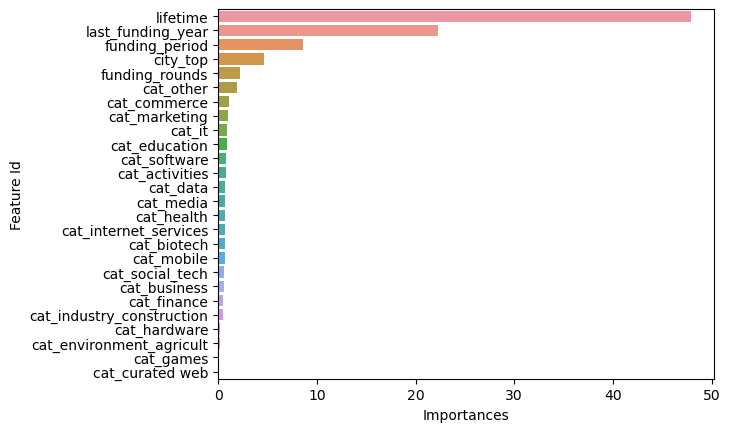

In [106]:
sns.barplot(
    x='Importances', 
    y='Feature Id', 
    data=feature_importance
);

Мы видим, что наиболее важными характеристиками для прогноза целевой переменной являются:
1. Срок жизни стартапа
2. Год последнего раунда финансирования
3. Период между первым и последним раундом
4. Город, в котором основан стартап
5. Число раундов финансирования

Категории сфер работы стартапа не настолько важны, хотя вероятно суммарно они дают довольно большой прирост к точности модели.

## Выводы

Таким образом, мы провели исследование основных предикторов того, будет ли жить стартап или закроется. Для выполнения этой задачи мы:
1. Загрузили данные и провели их предобработку - обработали пропуски, убрали дубликаты
2. Провели исследовательский анализ данных и проанализировали распределение данных
3. Сгенерировали фичи, которые позволили бы модели лучше справляться с нашими данными
4. Посмотрели данные на корреляции с целевой переменной и коллинеарность и отобрали финальный набор признаков для обучения модели
5. Обучили модель катбуст и выявили самые важные признаки для модели

На основе проведенного анализа можно сделать следующие выводы. Наиболее важными признаками для прогноза того, будет ли стартап жить или закроется, являются:
1. Срок жизни стартапа
2. Год последнего раунда финансирования
3. Период между первым и последним раундом
4. Город, в котором основан стартап
5. Число раундов финансирования

Построенная модель дала метрику F1 на валидации 0.92, а на тесте на приватной части на кэггле 0.84. Таким образом, можно сделать вывод, что модель, используя данные входящие признаки, достаточно хорошо прогнозирует целевую переменную. Возможные шаги для дальнейшего улучшения работы модели:
1. Попробовать другой способ обработки категории деятельности стартапов
2. Более тщательное и структурированное укрупнение категорий
3. Использование географических данных может дать некоторый прирост метрик модели
4. Более тщательная настройка гиперпараметров модели может также дать некоторый прирост результатов